# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [6]:
# Load the CIFAR10 data
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(49000, 1000, 10000)

In [7]:
from cs231n.features import *

# Extract features. For each image we will compute a Histogram of Oriented
# Gradients (HOG) as well as a color histogram using the hue channel in HSV
# color space. We form our final feature vector for each image by concatenating
# the HOG and color histogram feature vectors.
#
# Roughly speaking, HOG should capture the texture of the image while ignoring
# color information, and the color histogram represents the color of the input
# image while ignoring texture. As a result, we expect that using both together
# ought to work better than using either alone. Verifying this assumption would
# be a good thing to try for the bonus section.

# The hog_feature and color_histogram_hsv functions both operate on a single
# image and return a feature vector for that image. The extract_features
# function takes a set of images and a list of feature functions and evaluates
# each feature function on each image, storing the results in a matrix where
# each column is the concatenation of all feature vectors for a single image.

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=1)
mean_feat = np.expand_dims(mean_feat, axis=1)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=1)
std_feat = np.expand_dims(std_feat, axis=1)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.vstack([X_train_feats, np.ones((1, X_train_feats.shape[1]))])
X_val_feats = np.vstack([X_val_feats, np.ones((1, X_val_feats.shape[1]))])
X_test_feats = np.vstack([X_test_feats, np.ones((1, X_test_feats.shape[1]))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [8]:
print X_test_feats.shape

(155, 10000)


In [9]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
regularization_strengths = [5e-1, 1e-2, 5e-2, 1e-3, 5e-3, 1e-4, 5e-4]

results = {}
best_val = -1
best_svm = None

pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_svm. You might also want to play  #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

from cs231n.classifiers import LinearSVM
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs,
                  num_iters=3000, verbose=True)
        ac_train = np.mean(y_train == svm.predict(X_train_feats))
        ac_val = np.mean(y_val == svm.predict(X_val_feats))
        if ac_val > best_val:
            best_val = ac_val
            best_svm = svm
        key = (lr, rs)
        results[key] = ac_train, ac_val
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 3000: loss 9.006608
iteration 100 / 3000: loss 5.136608
iteration 200 / 3000: loss 4.430622
iteration 300 / 3000: loss 4.016296
iteration 400 / 3000: loss 3.870030
iteration 500 / 3000: loss 3.944028
iteration 600 / 3000: loss 3.726431
iteration 700 / 3000: loss 3.814281
iteration 800 / 3000: loss 4.023395
iteration 900 / 3000: loss 3.893044
iteration 1000 / 3000: loss 4.348061
iteration 1100 / 3000: loss 3.897517
iteration 1200 / 3000: loss 4.223415
iteration 1300 / 3000: loss 4.138552
iteration 1400 / 3000: loss 3.515918
iteration 1500 / 3000: loss 4.404410
iteration 1600 / 3000: loss 3.921067
iteration 1700 / 3000: loss 3.806610
iteration 1800 / 3000: loss 4.301078
iteration 1900 / 3000: loss 3.808311
iteration 2000 / 3000: loss 3.933122
iteration 2100 / 3000: loss 4.078061
iteration 2200 / 3000: loss 3.941360
iteration 2300 / 3000: loss 3.969588
iteration 2400 / 3000: loss 4.035860
iteration 2500 / 3000: loss 4.168367
iteration 2600 / 3000: loss 4.014883
iteration 270

In [5]:
# Finetuning
from cs231n.classifiers import LinearSVM
#lr, rs = 1e-2, 3e-2
#svm = LinearSVM()
lr, rs = 1e-6, 3e-2
svm = LinearSVM(svm.W)
svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs,
                  num_iters=1000, verbose=True)

iteration 0 / 1000: loss 8.993514
iteration 100 / 1000: loss 8.986095
iteration 200 / 1000: loss 8.969022
iteration 300 / 1000: loss 8.958938
iteration 400 / 1000: loss 8.953993
iteration 500 / 1000: loss 8.961984
iteration 600 / 1000: loss 8.930518
iteration 700 / 1000: loss 8.928287
iteration 800 / 1000: loss 8.940947
iteration 900 / 1000: loss 8.930834


[8.9935137663650675,
 8.9747166709115014,
 8.9898221616484797,
 8.9932949580681161,
 8.994275586003047,
 9.0034405425587138,
 8.9971715731921353,
 8.9810911276875718,
 9.0001206829157816,
 8.984250253697315,
 8.9953570708864365,
 9.0003360547612719,
 8.9946757432108697,
 8.9991643854714756,
 8.9913382962334456,
 8.9858374703793782,
 8.9899530136961161,
 9.0016322064408136,
 8.9837295289723418,
 8.9902733938381036,
 8.9977106986878113,
 8.9897924221553733,
 8.9893058874520424,
 8.9904191692384359,
 8.9821060590353756,
 8.9833381966590817,
 8.9947938830792591,
 8.9757492548229578,
 8.9870182578153219,
 8.985695354597242,
 8.9836462082137398,
 8.9866681017066021,
 9.0091233819745895,
 8.9892009511064508,
 8.9858769722748129,
 8.9874090179400632,
 8.9763684052645214,
 8.9779041977997807,
 8.9938203851235272,
 8.987593586115322,
 8.9852973863007488,
 8.9830288086156553,
 8.9904381307990811,
 8.9933739706180891,
 8.9999074258727099,
 8.9934258369640556,
 8.9836042027462621,
 8.99238600942577

In [10]:
y_test_pred = best_svm.predict(X_test_feats)
#y_test_pred = svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.4928


In [11]:
import pandas as pd
pd_actual = pd.Series(y_test_pred)
pd_predict = pd.Series(y_test)
confusion = pd.crosstab(pd_actual, pd_predict, 
                        rownames=['Actual'], colnames=['Predicted'])
confusion

Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,572,50,90,38,47,19,17,33,202,64
1,36,609,16,30,15,11,17,22,99,129
2,49,4,367,85,136,105,72,57,22,21
3,29,26,84,336,114,176,100,73,16,37
4,35,26,142,108,420,81,82,102,17,18
5,8,14,104,163,59,400,73,97,6,23
6,22,40,101,124,90,82,594,39,15,19
7,14,28,44,65,76,88,29,511,14,54
8,196,76,35,23,30,25,12,16,558,74


In [8]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:,:-1] # strip out the bias
w = w.reshape(10, 32, 32, 3)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

ValueError: total size of new array must be unchanged

(1000, 32, 32, 3)


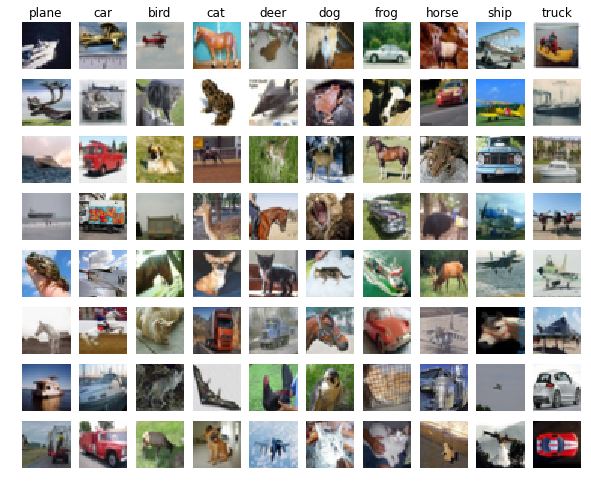

In [63]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

_, h, w, c = X_train.shape
print X_test.shape
examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!